In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0'
input_pkl_path_v1 = os.path.join(data_dir, 'input_nn_ver1.pkl')
#input_pkl_path_v2 = os.path.join(data_dir, 'input_nn_ver2.pkl')

In [ ]:
df = pd.read_pickle(input_pkl_path_v1)
#df = pd.read_pickle(input_pkl_path_v2)

**------------------NOISE ADDING----------------------**

In [ ]:
def add_noise(tsky, trx=75.0, snr=1000.0):
    tsys = trx + tsky
    tnoise = tsys / snr
    tcal = tsky + tnoise * np.random.standard_normal(tsky.shape)
    return tcal

In [ ]:
original_spectrum = np.array(df['SPECTRA_Tb[K]'].iloc[0])

In [ ]:
frequencies = np.linspace(20.0, 26.0, len(original_spectrum))

In [ ]:
noisy_spectrum = add_noise(original_spectrum)

In [ ]:
df['SPECTRA_Tb[K]_NOISY'] = df['SPECTRA_Tb[K]'].apply(lambda spec: add_noise(np.array(spec)))

**TRANING WAY 1: USING DIFFERENT COLUMNS BETWEEN PL AND H2O**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = np.array(df['SPECTRA_Tb[K]_NOISY'].tolist())
PL = np.array(df['PL[mbar]'].tolist())
H2O = np.array(df['H2O[vmr]'].tolist())
Y = np.concatenate([PL, H2O], axis=1)

In [ ]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [ ]:
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)

X_train: (12614, 12001)
X_val:   (4205, 12001)
X_test:  (4205, 12001)


In [ ]:
print("Y_train:", Y_train.shape)
print("Y_val:  ", Y_val.shape)
print("Y_test: ", Y_test.shape)

Y_train: (12614, 134)
Y_val:   (4205, 134)
Y_test:  (4205, 134)


**SECOND FRAMEWORK TORCH**

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**-NORMALIZATION-**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

**-----------------------**

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
Y_val   = torch.tensor(Y_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
Y_test  = torch.tensor(Y_test, dtype=torch.float32)

In [ ]:
batch_size = 64

In [ ]:
train_ds = TensorDataset(X_train, Y_train)
val_ds   = TensorDataset(X_val, Y_val)
test_ds  = TensorDataset(X_test, Y_test)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class PedroMLP(nn.Module):
    def __init__(self):
        super(PedroMLP, self).__init__()
        self.fc1 = nn.Linear(12001, 1024)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(128, 134)  # 67 H2O + 67 PL

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

model = PedroMLP()

In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = torch.tensor(weights, dtype=torch.float32)

    def forward(self, pred, target):
        diff = pred - target
        weighted_diff = diff * self.weights
        loss = torch.mean(weighted_diff ** 2)
        return loss

def smoothness_penalty(pred, n_levels, alpha=1.0):
    h2o = pred[:, n_levels:]  # Solo H2O
    diff = h2o[:, 1:] - h2o[:, :-1]
    return alpha * torch.mean(diff ** 2)

# Construct weights to emphasize lower pressures (higher in atmosphere)
n_levels = 67
pl_weights = np.linspace(1.0, 0.5, n_levels)      # Normal weights for PL
h2o_weights = np.logspace(np.log10(4.0), np.log10(0.3), n_levels)     # Emphasize high-altitude H2O

combined_weights = np.concatenate([pl_weights, h2o_weights])
criterion = WeightedMSELoss(weights=combined_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

In [ ]:
def train(model, loader, val_loader, criterion, optimizer, epochs, save_path):
    train_losses, val_losses = [], []
    val_mae_list, val_rmse_list = [], []

    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    counter = 0

    # Scheduler: reduce LR when val_loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                            factor=0.5, patience=5,
                                                            verbose=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            base_loss = criterion(preds, yb)
            smooth_loss = smoothness_penalty(preds, n_levels=67, alpha=0.5)
            loss = base_loss + smooth_loss
            loss.backward()

            # Optional: gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(loader))

        # Validation
        model.eval()
        val_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                val_loss += criterion(preds, yb).item()
                y_true.append(yb.numpy())
                y_pred.append(preds.numpy())

        val_losses.append(val_loss / len(val_loader))
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        val_mae = mean_absolute_error(y_true, y_pred)
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        val_mae_list.append(val_mae)
        val_rmse_list.append(val_rmse)

        # Update LR scheduler
        scheduler.step(val_losses[-1])
        current_lr = optimizer.param_groups[0]['lr']

        # Early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()
            counter = 0
            torch.save(best_model_state, save_path)
            print(f"✅ Model improved and saved (val_loss = {best_val_loss:.4f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"⛔ Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{epochs} | Base Loss: {base_loss.item():.4f} | Smooth Penalty: {smooth_loss.item():.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | MAE: {val_mae:.4f} | "
              f"RMSE: {val_rmse:.4f} | LR: {current_lr:.1e}")

    # Load best model after training
    model.load_state_dict(torch.load(save_path))

    return train_losses, val_losses, val_mae_list, val_rmse_list

In [ ]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            preds = model(xb)
            y_true.append(yb.numpy())
            y_pred.append(preds.numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    return y_true, y_pred

In [ ]:
save_path = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0/pedro_model5.pth'

In [ ]:
epochs = 100
train_losses, val_losses, val_mae, val_rmse = train(model, train_loader, val_loader, criterion, optimizer, epochs, save_path)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Model improved and saved (val_loss = 13059.2770)
Epoch 1/100 | Base Loss: 10341.6963 | Smooth Penalty: 253.0971 | Val Loss: 13059.2770 | MAE: 81.0311 | RMSE: 197.3283 | LR: 5.0e-04
✅ Model improved and saved (val_loss = 6900.8167)
Epoch 2/100 | Base Loss: 21298.6641 | Smooth Penalty: 68.9465 | Val Loss: 6900.8167 | MAE: 55.1407 | RMSE: 143.4646 | LR: 5.0e-04
Epoch 3/100 | Base Loss: 6479.0459 | Smooth Penalty: 8.1643 | Val Loss: 7311.5051 | MAE: 57.3030 | RMSE: 147.7165 | LR: 5.0e-04
Epoch 4/100 | Base Loss: 8187.9614 | Smooth Penalty: 4.8065 | Val Loss: 7057.4651 | MAE: 56.1373 | RMSE: 145.1056 | LR: 5.0e-04
Epoch 5/100 | Base Loss: 9378.0117 | Smooth Penalty: 6.1121 | Val Loss: 6925.2924 | MAE: 55.7942 | RMSE: 143.6711 | LR: 5.0e-04
✅ Model improved and saved (val_loss = 6761.5833)
Epoch 6/100 | Base Loss: 7846.4087 | Smooth Penalty: 0.9839 | Val Loss: 6761.5833 | MAE: 55.8333 | RMSE: 142.0168 | LR: 5.0e-04
✅ Model improved and saved (val_loss = 5817.1676)
Epoch 7/100 | Base Loss: 

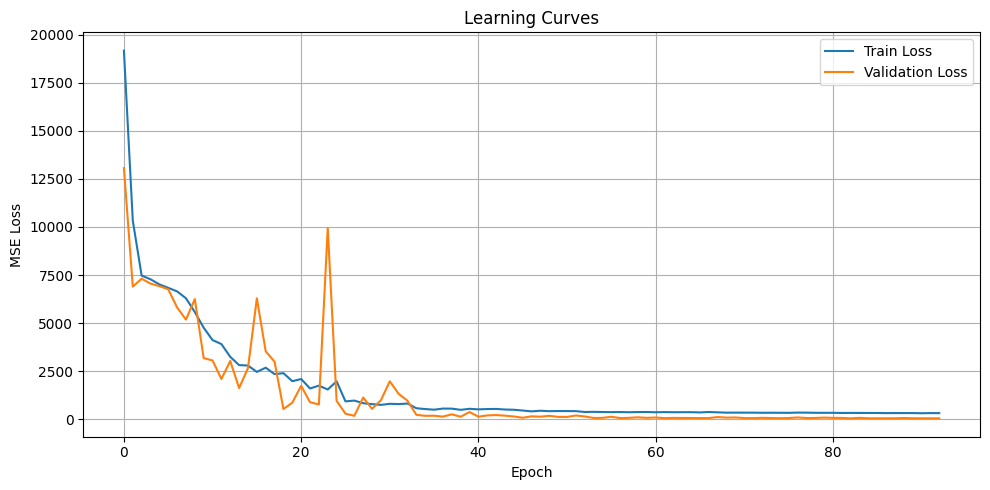

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
y_true_test, y_pred_test = evaluate(model, test_loader)

# Compute test metrics
test_mae = mean_absolute_error(y_true_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Test MAE: 4.4403
Test RMSE: 13.3410


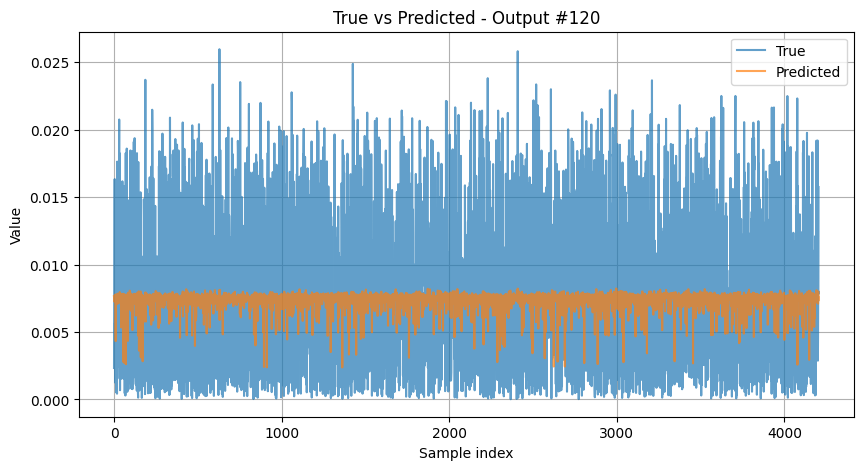

In [ ]:
output_index = 120  # choose any from 0 to 133

plt.figure(figsize=(10, 5))
plt.plot(y_true_test[:, output_index], label='True', alpha=0.7)
plt.plot(y_pred_test[:, output_index], label='Predicted', alpha=0.7)
plt.title(f"True vs Predicted - Output #{output_index}")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

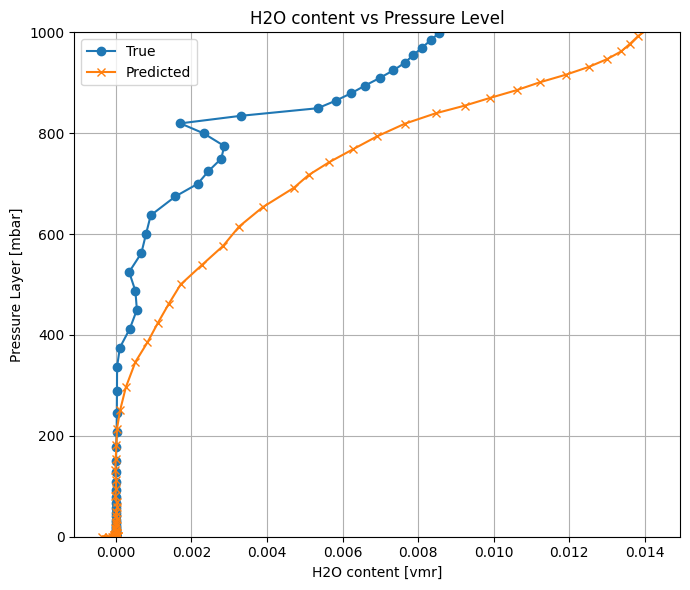

In [ ]:
# Split predictions and true labels
n_levels = y_true_test.shape[1] // 2  # 67 H2O + 67 PL

PL_true = y_true_test[:, :n_levels]
H2O_true = y_true_test[:, n_levels:]

PL_pred = y_pred_test[:, :n_levels]
H2O_pred = y_pred_test[:, n_levels:]

# Choose a sample index
i = 0  # change to visualize different examples

# Extract profiles
pl_profile_true = PL_true[i]
h2o_profile_true = H2O_true[i]

pl_profile_pred = PL_pred[i]
h2o_profile_pred = H2O_pred[i]

# Plot both true and predicted on same plot
plt.figure(figsize=(7, 6))
plt.plot(h2o_profile_true, pl_profile_true, label="True", marker='o')
plt.plot(h2o_profile_pred, pl_profile_pred, label="Predicted", marker='x')
plt.gca().invert_yaxis()
plt.xlabel("H2O content [vmr]")
plt.ylabel("Pressure Layer [mbar]")
plt.ylim(0, 1000)
plt.title("H2O content vs Pressure Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

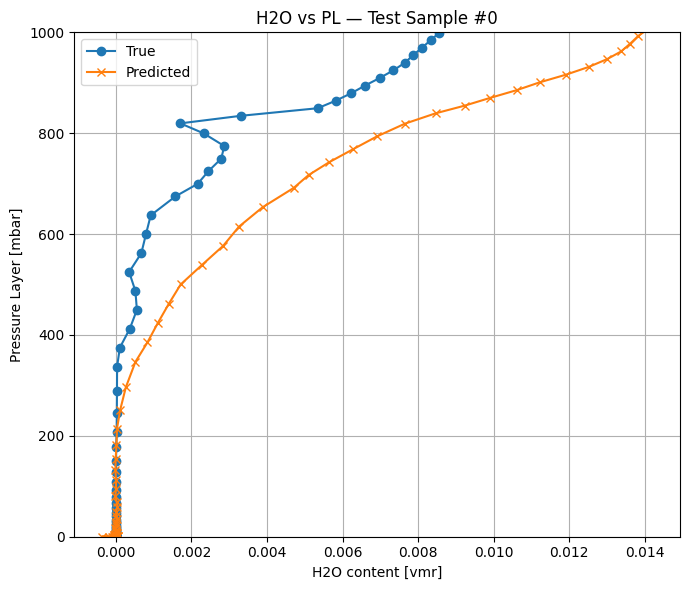

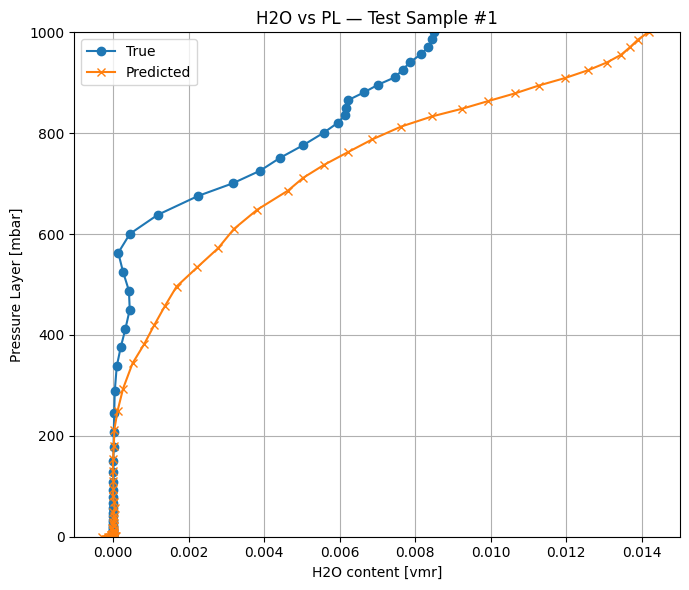

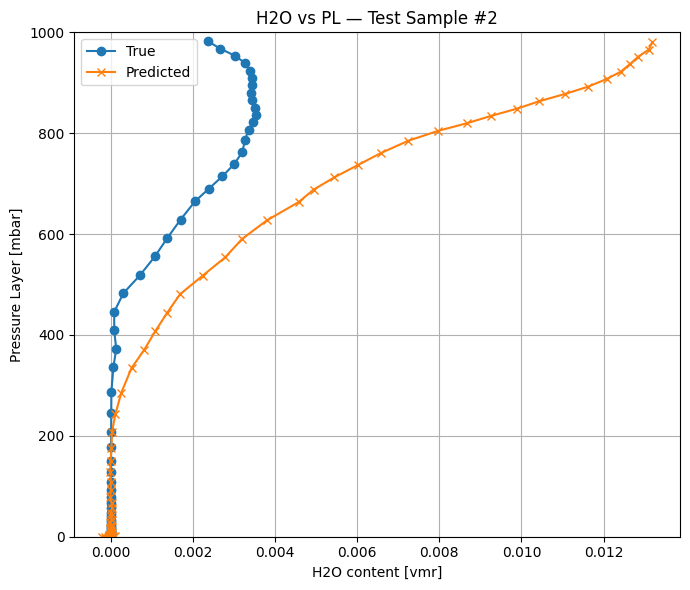

In [ ]:
for i in range(3):
    pl_profile_true = PL_true[i]
    h2o_profile_true = H2O_true[i]
    pl_profile_pred = PL_pred[i]
    h2o_profile_pred = H2O_pred[i]

    plt.figure(figsize=(7, 6))
    plt.plot(h2o_profile_true, pl_profile_true, label="True", marker='o')
    plt.plot(h2o_profile_pred, pl_profile_pred, label="Predicted", marker='x')
    plt.gca().invert_yaxis()
    plt.xlabel("H2O content [vmr]")
    plt.ylabel("Pressure Layer [mbar]")
    plt.ylim(0, 1000)
    plt.title(f"H2O vs PL — Test Sample #{i}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#torch.save(model.state_dict(), save_path)

In [ ]:
save_path_final = '/content/drive/MyDrive/NICOS_NN/SOLSTICIO2_0/pedro_model5_final.pth'
torch.save(model.state_dict(), save_path_final)